### Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import json
import re
import ast
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
import scipy.optimize as opt
from functools import partial
from scipy.stats import pearsonr
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings(
    "ignore",
    message=".*unsupported index was provided.*"  # a regex pattern
)

### Installs

In [2]:
%%capture
!pip install jsonpickle
!pip install pmdarima

### Pulling In Log Data

In [5]:
def parse_log_file(file_path):
    
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Extract sections
    sandbox_section = re.search(r'Sandbox logs:(.*?)Activities log:', content, re.DOTALL).group(1).strip()
    activities_section = re.search(r'Activities log:(.*?)Trade History:', content, re.DOTALL).group(1).strip()
    trade_section = re.search(r'Trade History:(.*?)$', content, re.DOTALL).group(1).strip()
    
    # Function to parse multi-line JSON objects
    def extract_json_objects(json_string):
        # Split the string into lines
        lines = json_string.strip().split('\n')
        
        # Initialize variables
        json_objects = []
        current_object = ""
        inside_object = False
        
        for idx, line in enumerate(lines):
            if line.strip().startswith('{'):
                inside_object = True
                current_object = line
            elif line.strip().endswith('}') and inside_object:
                current_object += line
                json_objects.append(json.loads(current_object))
                current_object = ""
                inside_object = False
            elif inside_object:
                current_object += line
        
        return json_objects
    
    # Parse each section
    sandbox_logs = extract_json_objects(sandbox_section)
    activities_list = pd.read_csv(StringIO(activities_section), sep=';')
    trade_list = ast.literal_eval(trade_section)

    sandbox_dicts = {}
    
    own_trades_df = pd.DataFrame(columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])

    market_trades_df = pd.DataFrame(columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])
    
    bid_df = pd.DataFrame(columns=['symbol','bid_price', 'bid_volume','timestamp'])
    ask_df = pd.DataFrame(columns=['symbol','ask_price', 'ask_volume','timestamp'])

    position_df = pd.DataFrame(columns=['symbol', 'position', 'timestamp'])

    trader_orders_df = pd.DataFrame(columns=['timestamp', 'symbol', 'price', 'quantity', 'type'])
    trader_data_df = pd.DataFrame(columns=['timestamp', 'symbol', 'orderbook_theo', 'signal_theo', 'forecast_theo', 'return', 'residual', 'expected_return'])

    timestamps  = list(range(0, 1 + (len(sandbox_logs) * 100), 100))

    market_trade_info_df = pd.DataFrame(columns=['timestamp', 'symbol', 'average_weighted_price', 'total_volume'])
    own_trade_info_df = pd.DataFrame(columns=['timestamp', 'symbol', 'average_weighted_price', 'total_volume'])

    for idx_log, log in enumerate(sandbox_logs):

        lambda_log = log['lambdaLog']
        try:
            if "LATEST\n" in lambda_log and "\nEND" in lambda_log:
                start_idx = lambda_log.find("LATEST\n") + len("LATEST\n")
                end_idx = lambda_log.find("\nEND")
                
                json_content = lambda_log[start_idx:end_idx]
                parsed = json.loads(json_content)

            else:
                parsed = json.loads(lambda_log)

        except:
            raise Exception("Error parsing log")
        

        sandbox_dicts[parsed['state']['timestamp']] = parsed

        parsed_own_trades_df = pd.DataFrame(parsed['state']["own_trades"], columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])

        parsed_own_trades_df = parsed_own_trades_df[parsed_own_trades_df['timestamp']  == parsed['state']['timestamp']- 100]

        if not parsed_own_trades_df.empty:
            own_trades_df = pd.concat([own_trades_df, parsed_own_trades_df], ignore_index=True)
            
        parsed_market_trades_df = pd.DataFrame(parsed['state']["market_trades"], columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])
        
        parsed_market_trades_df = parsed_market_trades_df[parsed_market_trades_df['timestamp']  == parsed['state']['timestamp']- 100]

        if not parsed_market_trades_df.empty:
            market_trades_df = pd.concat([market_trades_df, parsed_market_trades_df], ignore_index=True)

        for symbol, depth in parsed['state']['order_depths'].items():

            parsed_bid_df = pd.DataFrame(list(depth[0].items()), columns=['bid_price', 'bid_volume'])
            parsed_ask_df = pd.DataFrame(list(depth[1].items()), columns=['ask_price', 'ask_volume'])

            parsed_ask_df['ask_volume'] = np.abs(parsed_ask_df['ask_volume'])

            parsed_bid_df['symbol'] = symbol
            parsed_ask_df['symbol'] = symbol

            parsed_bid_df['timestamp'] = parsed['state']['timestamp']
            parsed_ask_df['timestamp'] = parsed['state']['timestamp']
            
            bid_df = pd.concat([bid_df, parsed_bid_df], ignore_index=True)
            ask_df = pd.concat([ask_df, parsed_ask_df], ignore_index=True)

        parsed_position_df = pd.DataFrame(list(parsed['state']['position'].items()), columns=['symbol', 'position'])

        parsed_position_df['timestamp'] = parsed['state']['timestamp']

        position_df = pd.concat([position_df, parsed_position_df], ignore_index=True)
        
        parsed_trader_data = json.loads(parsed['state']['trader_data'])

        orders_df = pd.DataFrame(columns = ['symbol', 'price', 'quantity', 'type', 'order_type','offset_asked'])

        symbol_list = list(parsed_trader_data['orderbook_theos'].keys())
        info_df = pd.DataFrame({'symbol': symbol_list,
                                     'orderbook_theo': [parsed_trader_data['orderbook_theos'][symbol][-1] for symbol in symbol_list],
                                     'signal_theo': [parsed_trader_data['signal_theos'][symbol][-1] for symbol in symbol_list],
                                     'forecast_theo': [parsed_trader_data['forecast_theos'][symbol][-1] for symbol in symbol_list],
                                        'return': [parsed_trader_data['returns'][symbol][-1] for symbol in symbol_list],
                                        'residual': [parsed_trader_data['residuals'][symbol][-1] for symbol in symbol_list],
                                        'expected_return': [parsed_trader_data['expected_return'][symbol] for symbol in symbol_list]
                                        })
        
        info_df['timestamp'] = parsed['state']['timestamp']

        market_trade_info_df = pd.concat([market_trade_info_df, pd.DataFrame({'timestamp': parsed['state']['timestamp'],
                                             'symbol': list(parsed_trader_data['market_trades_data'].keys()),
                                             'average_weighted_price': [values['average_weighted_price'] for values in parsed_trader_data['market_trades_data'].values()],
                                             'total_volume': [values['total_volume'] for values in parsed_trader_data['market_trades_data'].values()],
                                        })], ignore_index=True)
        
        own_trade_info_df = pd.concat([own_trade_info_df, pd.DataFrame({'timestamp': parsed['state']['timestamp'],
                                        'symbol': list(parsed_trader_data['own_trades_data'].keys()),
                                        'average_weighted_price': [values['average_weighted_price'] for values in parsed_trader_data['own_trades_data'].values()],
                                        'total_volume': [values['total_volume'] for values in parsed_trader_data['own_trades_data'].values()],
                                })], ignore_index=True)


        for symbol in parsed_trader_data['maker_orders'].keys():
            maker_orders_df = pd.DataFrame(parsed_trader_data['maker_orders'][symbol], columns=['symbol', 'price', 'quantity','offset_asked']) if len(parsed_trader_data['maker_orders'][symbol]) > 0 else pd.DataFrame(columns=['symbol', 'price', 'quantity','offset_asked'])
            taker_orders_df = pd.DataFrame(parsed_trader_data['taker_orders'][symbol], columns=['symbol', 'price', 'quantity']) if len(parsed_trader_data['taker_orders'][symbol]) > 0 else pd.DataFrame(columns=['symbol', 'price', 'quantity'])

            maker_orders_df['type'] = 'maker'
            taker_orders_df['type'] = 'taker'
            taker_orders_df['offset_asked'] = np.nan

            dfs_to_concat = [df for df in [orders_df, maker_orders_df, taker_orders_df] if not df.empty]
            if dfs_to_concat: 
                orders_df = pd.concat(dfs_to_concat, ignore_index=True)


        orders_df['timestamp'] = parsed['state']['timestamp']
    
        if not info_df.empty:
            trader_data_df = pd.concat([trader_data_df, info_df], ignore_index=True)
        if not orders_df.empty:
            trader_orders_df = pd.concat([trader_orders_df, orders_df], ignore_index=True)

    trader_data_df = trader_data_df.groupby('symbol').apply(
        lambda x: x.assign(**{'return': x['return'].shift(-1)})
    ).sort_values('timestamp').reset_index(drop=True)
    
    trader_data_df['return'] = trader_data_df['return'].fillna(0)

    market_trades_df = market_trades_df.sort_values('timestamp')
    
    symbols = position_df['symbol'].unique()

    result_dfs = []

    for symbol in symbols:
        symbol_data = position_df[position_df['symbol'] == symbol]

        symbol_all_times = pd.DataFrame({
                'symbol': symbol,
                'timestamp': timestamps
            })
        
        symbol_merged = pd.merge(symbol_all_times, symbol_data, 
                                    on=['symbol', 'timestamp'], how='left')
            
        symbol_merged = symbol_merged.sort_values('timestamp')
        symbol_merged['position'] = symbol_merged['position'].ffill().fillna(0).astype('float64')

        result_dfs.append(symbol_merged)

    position_df = pd.concat(result_dfs, ignore_index=True)

    activities_df, trade_history_df = pd.DataFrame(activities_list), pd.DataFrame(trade_list)

    # Conversion for market_trade_info_df
    market_trade_info_df['timestamp'] = market_trade_info_df['timestamp'].astype(int)
    market_trade_info_df['symbol'] = market_trade_info_df['symbol'].astype(str)
    market_trade_info_df['average_weighted_price'] = market_trade_info_df['average_weighted_price'].astype(float)
    market_trade_info_df['total_volume'] = market_trade_info_df['total_volume'].astype(int)

    own_trade_info_df['timestamp'] = own_trade_info_df['timestamp'].astype(int)
    own_trade_info_df['symbol'] = own_trade_info_df['symbol'].astype(str)
    own_trade_info_df['average_weighted_price'] = own_trade_info_df['average_weighted_price'].astype(float)
    own_trade_info_df['total_volume'] = own_trade_info_df['total_volume'].astype(int)

    # Conversion for trader_orders_df
    trader_orders_df['timestamp'] = trader_orders_df['timestamp'].astype(int)
    trader_orders_df['symbol'] = trader_orders_df['symbol'].astype(str)
    trader_orders_df['price'] = trader_orders_df['price'].astype(int)
    trader_orders_df['quantity'] = trader_orders_df['quantity'].astype(int)
    trader_orders_df['type'] = trader_orders_df['type'].astype(str)
    # offset_asked is already float64

    # Conversion for trader_data_df
    trader_data_df['timestamp'] = trader_data_df['timestamp'].astype(int)
    trader_data_df['symbol'] = trader_data_df['symbol'].astype(str)
    trader_data_df['orderbook_theo'] = trader_data_df['orderbook_theo'].astype(float)
    trader_data_df['signal_theo'] = trader_data_df['signal_theo'].astype(float)
    trader_data_df['forecast_theo'] = trader_data_df['forecast_theo'].astype(float)

    # Conversion for position_df
    position_df['symbol'] = position_df['symbol'].astype(str)
    position_df['timestamp'] = position_df['timestamp'].astype(int)
    # position is already float64

    # Conversion for bid_df
    bid_df['symbol'] = bid_df['symbol'].astype(str)
    bid_df['bid_price'] = bid_df['bid_price'].astype(int)
    bid_df['bid_volume'] = bid_df['bid_volume'].astype(int)
    bid_df['timestamp'] = bid_df['timestamp'].astype(int)

    # Conversion for ask_df
    ask_df['symbol'] = ask_df['symbol'].astype(str)
    ask_df['ask_price'] = ask_df['ask_price'].astype(int)
    ask_df['ask_volume'] = ask_df['ask_volume'].astype(int)
    ask_df['timestamp'] = ask_df['timestamp'].astype(int)

    # Conversion for own_trades_df
    own_trades_df['symbol'] = own_trades_df['symbol'].astype(str)
    # price is already float64
    own_trades_df['quantity'] = own_trades_df['quantity'].astype(int)
    own_trades_df['buyer'] = own_trades_df['buyer'].astype(str)
    own_trades_df['seller'] = own_trades_df['seller'].astype(str)
    own_trades_df['timestamp'] = own_trades_df['timestamp'].astype(int)

    # Conversion for market_trades_df
    market_trades_df['symbol'] = market_trades_df['symbol'].astype(str)
    # price is already float64
    market_trades_df['quantity'] = market_trades_df['quantity'].astype(int)
    market_trades_df['buyer'] = market_trades_df['buyer'].astype(str)
    market_trades_df['seller'] = market_trades_df['seller'].astype(str)
    market_trades_df['timestamp'] = market_trades_df['timestamp'].astype(int)

    activities_df['product'] = activities_df['product'].astype(str)

    trade_history_df['buyer'] = trade_history_df['buyer'].astype(str)
    trade_history_df['seller'] = trade_history_df['seller'].astype(str)
    trade_history_df['symbol'] = trade_history_df['symbol'].astype(str)
    trade_history_df['currency'] = trade_history_df['currency'].astype(str)

    return sandbox_dicts, market_trade_info_df, own_trade_info_df, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  activities_df, trade_history_df


In [7]:
log_file_path = "C://Users//marco//Downloads//471781c4-5ac5-42c7-9618-10d3eb707061.log"

sandbox_dicts, market_trade_info_df, own_trade_info_df, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  activities_df, trade_history_df = parse_log_file(log_file_path)

C:\Users\marco\AppData\Local\Temp\ipykernel_19088\3744554144.py:164: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trader_data_df = trader_data_df.groupby('symbol').apply(


In [8]:
market_trade_info_df_copy, own_trade_info_df_copy, trader_orders_df_copy, trader_data_df_copy, position_df_copy, bid_df_copy, ask_df_copy, own_trades_df_copy, market_trades_df_copy,  activities_df_copy, trade_history_df_copy = market_trade_info_df.copy(), own_trade_info_df.copy(), trader_orders_df.copy(), trader_data_df.copy(), position_df.copy(), bid_df.copy(), ask_df.copy(), own_trades_df.copy(), market_trades_df.copy(),  activities_df.copy(), trade_history_df.copy()

In [9]:
market_trade_info_df, own_trade_info_df, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  activities_df, trade_history_df = market_trade_info_df_copy.copy(), own_trade_info_df_copy.copy(), trader_orders_df_copy.copy(), trader_data_df_copy.copy(), position_df_copy.copy(), bid_df_copy.copy(), ask_df_copy.copy(), own_trades_df_copy.copy(), market_trades_df_copy.copy(),  activities_df_copy.copy(), trade_history_df_copy.copy()


### Description of All of the Dataframes

1.   market_trade_info_df: average weighted price, total_volume traded of market trades during timestamp

        We receive information about these trades in run() at timestamp t + 100

2.   own_trade_info_df: average weighted price, total_volume traded of own trades during timestamp

        We receive information about these trades in run() at timestamp t + 100

3.   trader_orders_df: timestamp, price, quantity, type of order (maker or taker), and offset demanded if maker

        Explaining Offset Demanded:
        - If the trader is a maker, the offset demanded is (Edge of Order Price to Theo) / (Std of Price Return)

4.   trader_data_df: timestamp, symbol, orderbook_theo, signal_theo, return, residual, expected_return

5.   position_df: current position at timestamp t

6.   bid_df: symbol, bid price, volume, timestamp

7.   ask_df: symbol, ask price, volume, timestamp

8.   own_trades_df: symbol, price, quantity, buyer, seller, timestamp

9.   market_trades_df: symbol, price, quantity, buyer, seller, timestamp

9.   activities_df: day, timestamp, product, Top 3 Order Book Levels, mid_price, profit_and_loss

10.  trade_history_df: market_trades_df + own_trades_df

### Sandbox Dictionary

1.   Parsed Dictionary From JSON


## Generating Theo = f(Orderbook, Market Trades, Own Trades)

Our goal is to generate a theo that is as close as possible to imc_theo_(t+1). We want every single trade we make to mark in as well as possible.



### Functions

In [10]:
def build_position_trajectory_with_pnl(own_trades: pd.DataFrame) -> pd.DataFrame:
    trades_sorted = own_trades.sort_values(by="timestamp").copy()
    pos_records = [{
            "timestamp": 0,
            "product": product,
            "position": 0,
            "cost_basis": np.nan,
            "realized_pnl": np.nan,
            "realized_pnl_cum": np.nan,
        } for product in own_trades['symbol'].unique()]
    
    # Track state by product
    state = {}
    
    for _, row in trades_sorted.iterrows():
        product = row["symbol"]
        t = row["timestamp"]
        qty = row["quantity"]
        px = row["price"]
        
        # Determine if we're buying or selling
        if row["buyer"] == "SUBMISSION":
            delta_pos = +qty  # We're buying
        elif row["seller"] == "SUBMISSION":
            delta_pos = -qty  # We're selling
        else:
            continue  # Not our trade
        
        # Initialize state for this product if not seen before
        if product not in state:
            state[product] = {
                "pos": 0.0,
                "cost_basis": 0.0,
                "realized_cum": 0.0
            }
        
        old_pos = state[product]["pos"]
        old_cb = state[product]["cost_basis"]
        old_realized = state[product]["realized_cum"]
                
        # Determine if we're opening, increasing, reducing, or closing a position
        if abs(old_pos) < 1e-10:  # No existing position
        # Opening a new position
            new_pos = delta_pos
            new_cb = px
            trade_realized = 0.0
        elif (old_pos > 0 and delta_pos > 0) or (old_pos < 0 and delta_pos < 0):
            total_pos = old_pos + delta_pos
            new_cb = (old_pos * old_cb + delta_pos * px) / total_pos
            new_pos = total_pos
            trade_realized = 0.0
        elif (old_pos > 0 and delta_pos < 0) or (old_pos < 0 and delta_pos > 0):
            # Trade in opposite direction of position
            # First determine if we're reducing or flipping the position
            if abs(delta_pos) <= abs(old_pos):
                # Reducing position
                trade_realized = -delta_pos * (px - old_cb) if old_pos > 0 else delta_pos * (old_cb - px)
                
                new_pos = old_pos + delta_pos
                new_cb = old_cb  # Cost basis stays the same when reducing
            else:

                # Flipping position (close existing and open new in opposite direction)
                # Calculate PnL on the closed portion
                trade_realized = old_pos * (px - old_cb) if old_pos > 0 else -old_pos * (old_cb - px)
                # # Remaining quantity becomes a new position
                new_pos = old_pos + delta_pos
                new_cb = px  # New cost basis is this trade's price
        else:
            trade_realized, new_pos, new_cb = 0, old_pos, old_cb

        # Update cumulative realized PnL
        new_realized_cum = old_realized + trade_realized
        
        # Clean up tiny values due to floating point issues
        if abs(new_pos) < 1e-10:
            new_pos = 0.0
            new_cb = 0.0

        # Update state
        state[product]["pos"] = new_pos
        state[product]["cost_basis"] = new_cb
        state[product]["realized_cum"] = new_realized_cum

        # Record this position update
        pos_records.append({
            "timestamp": t + 100,
            "product": product,
            "position": new_pos,
            "cost_basis": new_cb,
            "realized_pnl": trade_realized,
            "realized_pnl_cum": new_realized_cum
        })
    
    position_df = pd.DataFrame(pos_records)
    
    position_df = (
        position_df
        .sort_values(["product", "timestamp"])
        .groupby(["product", "timestamp"], as_index=False)
        .last()
    )
    
    return position_df

In [31]:
def calculate_theo_for_row(row: pd.Series, betas: tuple) -> float:

    second_level_weight, third_level_weight, own_trades_weight, market_trades_weight = betas

    weights = [1, second_level_weight, third_level_weight]

    total_bid_weight, total_ask_weight, total_bid_volume, total_ask_volume, weighted_bid_price, weighted_ask_price = 0, 0, 0, 0, 0, 0

    for idx in range(1, 4):
        if pd.notna(row[f"bid_price_{idx}"]) and pd.notna(row[f"bid_volume_{idx}"]) and row[f"bid_volume_{idx}"]>0:
            total_bid_weight += row[f"bid_volume_{idx}"] * weights[idx - 1]
            total_bid_volume += row[f"bid_volume_{idx}"]
            weighted_bid_price += row[f"bid_price_{idx}"] * row[f"bid_volume_{idx}"] * weights[idx - 1]

        if pd.notna(row[f"ask_price_{idx}"]) and pd.notna(row[f"ask_volume_{idx}"]) and row[f"ask_volume_{idx}"]>0:
            total_ask_weight += row[f"ask_volume_{idx}"] * weights[idx - 1]
            total_ask_volume += row[f"ask_volume_{idx}"]
            weighted_ask_price += row[f"ask_price_{idx}"] * row[f"ask_volume_{idx}"] * weights[idx - 1]

    if total_bid_weight == 0 or total_ask_weight == 0:
        return np.nan

    weighted_bid_price /= total_bid_weight
    weighted_ask_price /= total_ask_weight

    own_volume = row['total_volume_own'] * own_trades_weight
    market_volume = row['total_volume_market'] * market_trades_weight
    own_weighted_average_price = row['average_weighted_price_own'] * own_volume if own_volume > 0 else 0
    market_weighted_average_price = row['average_weighted_price_market'] * market_volume if market_volume > 0 else 0

    total_volume = total_bid_volume + total_ask_volume + own_volume + market_volume
    
    if total_volume < 1e-9:
        return np.nan
    
    microprice = (weighted_bid_price * total_ask_volume + weighted_ask_price * total_bid_volume + own_weighted_average_price + market_weighted_average_price)  / total_volume

    return microprice


def calculate_theo_for_row_filtered(row: pd.Series, min_quote_quantity: float) -> float:

    total_bid_weight, total_ask_weight, total_bid_volume, total_ask_volume, weighted_bid_price, weighted_ask_price = 0, 0, 0, 0, 0, 0

    for idx in range(1, 4):
        if pd.notna(row[f"bid_price_{idx}"]) and pd.notna(row[f"bid_volume_{idx}"]) and row[f"bid_volume_{idx}"]> min_quote_quantity:
            total_bid_weight += row[f"bid_volume_{idx}"]
            total_bid_volume += row[f"bid_volume_{idx}"]
            weighted_bid_price += row[f"bid_price_{idx}"] * row[f"bid_volume_{idx}"]

        if pd.notna(row[f"ask_price_{idx}"]) and pd.notna(row[f"ask_volume_{idx}"]) and row[f"ask_volume_{idx}"]> min_quote_quantity:
            total_ask_weight += row[f"ask_volume_{idx}"] 
            total_ask_volume += row[f"ask_volume_{idx}"]
            weighted_ask_price += row[f"ask_price_{idx}"] * row[f"ask_volume_{idx}"]

    if total_bid_weight == 0 or total_ask_weight == 0:
        return np.nan

    weighted_bid_price /= total_bid_weight
    weighted_ask_price /= total_ask_weight

    total_volume = total_bid_volume + total_ask_volume
    
    if total_volume < 1e-9:
        return np.nan
    
    microprice = (weighted_bid_price * total_ask_volume + weighted_ask_price * total_bid_volume)  / total_volume

    return microprice

In [19]:
def mse_pnl(df, betas, theo_function, verbose=False):

    df["theo_price"] = df.apply(lambda x: theo_function(x, betas), axis=1)

    df["error_theo"] = df["imc_theo"] - df["theo_price"]

    if verbose:
        print(betas)

    mse = np.mean(df[~np.isnan(df['error_theo'])]["error_theo"]**2)

    return df, mse

In [22]:
def objective(betas, df, theo_function, verbose=False):

    _, mse_val = mse_pnl(
        df,
        betas,
        theo_function,
        verbose=verbose
    )
    
    return mse_val

In [14]:
symbols = own_trades_df['symbol'].unique()
timestamps = list(sorted(activities_df['timestamp'].unique()))

position_pnl_df = build_position_trajectory_with_pnl(own_trades_df)

result_dfs = []

for symbol in symbols:

    symbol_data = position_pnl_df[position_pnl_df['product'] ==  symbol]

    symbol_all_times = pd.DataFrame({
            'product': symbol,
            'timestamp': timestamps
        })
    
    symbol_merged = pd.merge(symbol_all_times, symbol_data, 
                                on=['product', 'timestamp'], how='left')
        
    symbol_merged = symbol_merged.sort_values('timestamp')
    symbol_merged['position'] = symbol_merged['position'].ffill().fillna(0).astype('float64')

    result_dfs.append(symbol_merged)

position_df = pd.concat(result_dfs, ignore_index=True)

activities_df = activities_df.sort_values(["product", "timestamp"], ascending=[True, True])
position_df = position_df.sort_values(["product", "timestamp"], ascending=[True, True])

In [63]:
merged_product_dict = {}

for product in position_df['product'].unique():

    merged_product_df = pd.merge(
        activities_df[activities_df['product'] == product],
        position_pnl_df[position_pnl_df['product'] == product],
        on=["product","timestamp"],
        how = "left"
    ).rename(columns={'product': 'symbol'}).merge(
        market_trade_info_df[market_trade_info_df['symbol'] == product],
        on=['timestamp', 'symbol'],
        suffixes=('', '_market'),
        how='left'
    ).rename(columns={'total_volume': 'total_volume_market', 'average_weighted_price': 'average_weighted_price_market'}).merge(
        own_trade_info_df[own_trade_info_df['symbol'] == product],
        on=['timestamp', 'symbol'],
        suffixes=('', '_own'),
        how='left'
    ).rename(columns={'total_volume': 'total_volume_own', 'average_weighted_price': 'average_weighted_price_own'})

    merged_product_df[["position", "cost_basis", "realized_pnl", "realized_pnl_cum"]] = merged_product_df[["position", "cost_basis", "realized_pnl", "realized_pnl_cum"]].ffill().fillna(0.0)


    merged_product_df["imc_theo"] =  np.where(merged_product_df['position'] == 0,
                                   np.nan,
                                   merged_product_df['cost_basis'] + ((merged_product_df['profit_and_loss'] - merged_product_df['realized_pnl_cum']) / merged_product_df['position']))
    
    merged_product_df["imc_theo"] = merged_product_df["imc_theo"].ffill()

    merged_product_dict[product] = merged_product_df

### Min Quantity

In [57]:

theo_min_volume_plot = {}
cleaned_theos = {}

for product in position_df['product'].unique():

    merged_product_df = merged_product_dict[product]

    theo_min_volume_plot[product] = []

    for min_quantity_volume in range(0, 30):


        mse_df, mse_val = mse_pnl(
            betas = min_quantity_volume,
            df = merged_product_df,
            theo_function = calculate_theo_for_row_filtered,
            verbose=False
        )
        
        theo_min_volume_plot[product].append(mse_val)


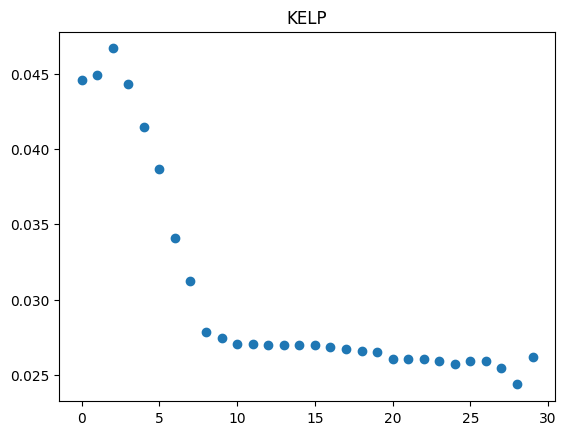

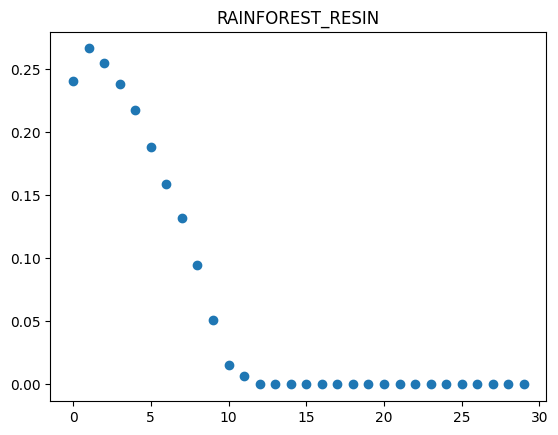

In [58]:
for product in position_df['product'].unique():
    plt.scatter(range(0,30), theo_min_volume_plot[product])
    plt.title(product)
    plt.show()

In [65]:
theo_min_volume = {'KELP' : 10, 'RAINFOREST_RESIN': 12}

for product in position_df['product'].unique():

    merged_product_df = merged_product_dict[product]

    mse_df, mse_val = mse_pnl(
        betas = theo_min_volume[product],
        df = merged_product_df,
        theo_function = calculate_theo_for_row_filtered,
        verbose=False
    )

    cleaned_theos[product] = mse_df[['timestamp', 'theo_price','imc_theo']].copy()

    cleaned_theos[product].loc[:, 'return_theo'] = cleaned_theos[product]['theo_price'].pct_change().shift(-1).fillna(0)
    cleaned_theos[product].loc[:, 'return_imc'] = cleaned_theos[product]['imc_theo'].pct_change().shift(-1).fillna(0)
    cleaned_theos[product].loc[:, 'return_mtm'] = (cleaned_theos[product]['imc_theo'].shift(-1) / cleaned_theos[product]['theo_price']) - 1
    cleaned_theos[product].loc[:, 'next_imc_theo'] = cleaned_theos[product]['imc_theo'].shift(-1)


cleaned_theos_df = pd.concat(cleaned_theos.values(), keys=cleaned_theos.keys(), ignore_index=False)
cleaned_theos_df = cleaned_theos_df.reset_index(level=0).rename(columns={'level_0': 'symbol'})

### Orderbook Level Weighting

In [40]:
init_guess = (1, 1, 1, 1)
init_guess_one_level = (0, 0, 0, 0)

bounds = [(0, 20)]*4

theo_betas = {}
cleaned_theos = {}

for product in position_df['product'].unique():

    merged_product_df = merged_product_dict[product]

    init_one_level_params_mse = objective(init_guess_one_level,
                         merged_product_df,
                         calculate_theo_for_row)
    
    init_params_mse = objective(init_guess,
                         merged_product_df,
                         calculate_theo_for_row)
    
    product_objective = partial(objective,
                               df = merged_product_df,
                               theo_function = calculate_theo_for_row,
                               verbose=False)
    
    result = opt.minimize(
        product_objective,
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        options={"eps": 1e-4}
    )

    mse_df, mse_val = mse_pnl(
        betas = result.x,
        df = merged_product_df,
        theo_function = calculate_theo_for_row,
        verbose=False
    )

    cleaned_theos[product] = mse_df[['timestamp', 'theo_price','imc_theo']].copy()

    cleaned_theos[product].loc[:, 'return_theo'] = cleaned_theos[product]['theo_price'].pct_change().shift(-1).fillna(0)
    cleaned_theos[product].loc[:, 'return_imc'] = cleaned_theos[product]['imc_theo'].pct_change().shift(-1).fillna(0)
    cleaned_theos[product].loc[:, 'return_mtm'] = (cleaned_theos[product]['imc_theo'].shift(-1) / cleaned_theos[product]['theo_price']) - 1
    cleaned_theos[product].loc[:, 'next_imc_theo'] = cleaned_theos[product]['imc_theo'].shift(-1)

    print(f"Optimization result for product {product}:", result)
    print(f"Best betas for product {product}:", result.x)
    print(f"One Level Raw MSE for product {product}:", init_one_level_params_mse)
    print(f"Three Level Raw MSE for product {product}:", init_params_mse)
    print(f"MSE for product {product}:", result.fun)

    theo_betas[product] = result.x


cleaned_theos_df = pd.concat(cleaned_theos.values(), keys=cleaned_theos.keys(), ignore_index=False)
cleaned_theos_df = cleaned_theos_df.reset_index(level=0).rename(columns={'level_0': 'symbol'})

Optimization result for product KELP:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.03471546370179679
       x: [ 6.000e+00  4.119e+00  1.271e-01  6.413e-02]
     nit: 22
     jac: [-3.594e-05 -4.269e-04 -3.319e-05  3.378e-05]
    nfev: 110
    njev: 22
Best betas for product KELP: [6.         4.11918328 0.12713368 0.06412664]
One Level Raw MSE for product KELP: 0.32090396942955474
Three Level Raw MSE for product KELP: 0.06412527034134068
MSE for product KELP: 0.03471546370179679
Optimization result for product RAINFOREST_RESIN:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1403582088553513
       x: [ 6.000e+00  6.000e+00  1.684e-01  4.537e-01]
     nit: 27
     jac: [-4.345e-04 -2.170e-03 -9.745e-05 -2.960e-05]
    nfev: 135
    njev: 27
Best betas for product RAINFOREST_RESIN: [6.         6.         0.16843249 0.45367273]
One Level Raw MSE for product RAINFOREST_RESIN: 2.4293186970453866
Three Level Raw 

### Verification of IMC Theo

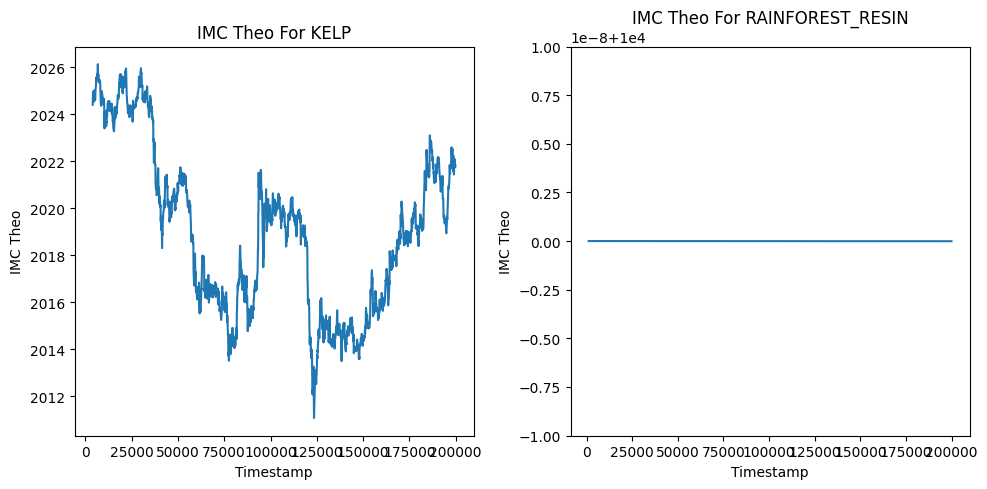

In [42]:
n_symbols = len(cleaned_theos.keys())

fig, axes = plt.subplots(1, n_symbols, figsize=(5*n_symbols, 5))

if n_symbols == 1:
    axes = np.array([axes])

for i, symbol in enumerate(cleaned_theos.keys()):

    axes[i].plot(cleaned_theos[symbol]['timestamp'], cleaned_theos[symbol]['imc_theo'])
    axes[i].set_title(f'IMC Theo For {symbol}')
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel('IMC Theo')

plt.tight_layout()
plt.show()

### Examining Size for Adverse Taking

In [ ]:
# Code

adverse_taking_quantities = {}
for product in position_df['product'].unique():

    merged_product_df = merged_product_dict[product]

    for each product. examine the quantity of orders that look good to my theo, that are bad relative to IMC_theo
        

    adverse_taking_quantities[product] = adverse_taking_quantity

## Signal Creation

### Examining Autocorrelation

Idea

1.   For x in products:
2.   For y in products:
3.   Given whitened_x_[return_theo]
4.   Examine at what lags h, h > 1, x_[return_theo]_{t - h} is significant in predicting y_[return_mtm]_t



Examining KELP Prediction Power On KELP


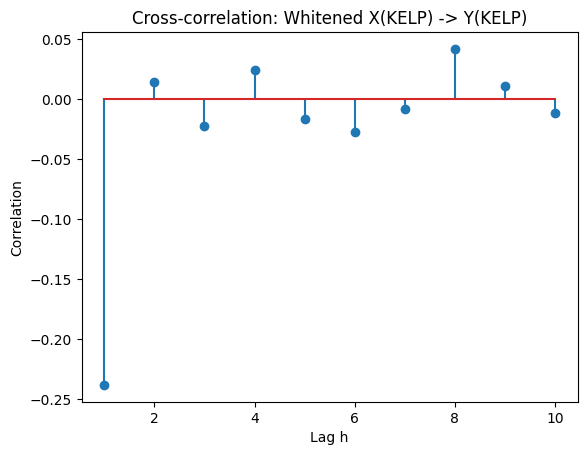

Examining RAINFOREST_RESIN Prediction Power On KELP


C:\Users\marco\AppData\Local\Temp\ipykernel_19088\133962807.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x_shifted[valid_mask], y[valid_mask])


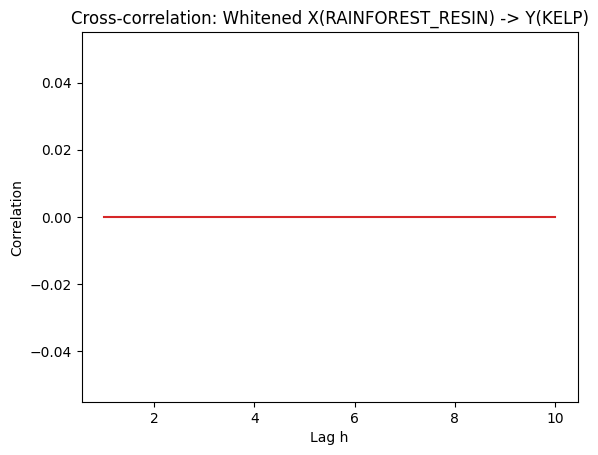

Examining KELP Prediction Power On RAINFOREST_RESIN


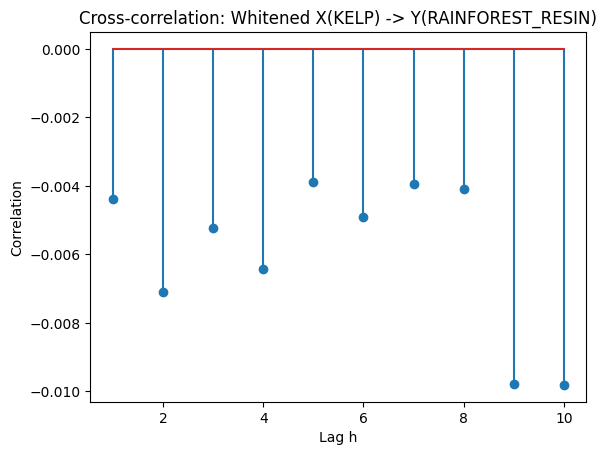

Examining RAINFOREST_RESIN Prediction Power On RAINFOREST_RESIN


C:\Users\marco\AppData\Local\Temp\ipykernel_19088\133962807.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x_shifted[valid_mask], y[valid_mask])


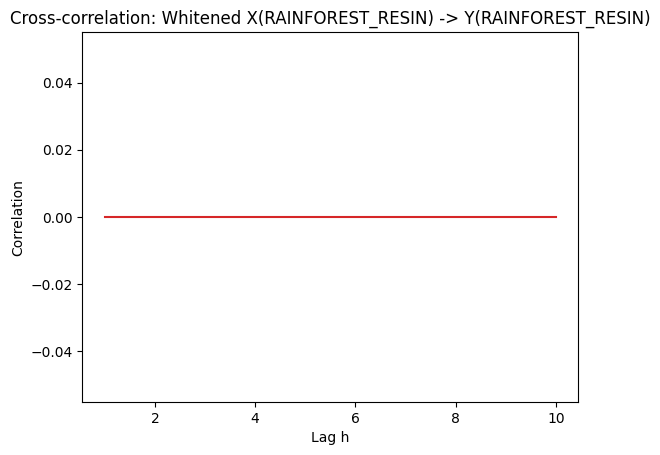

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.arima.model import ARIMA

products = cleaned_theos.keys()
significant_lags_dict = {}

plot_cross_correlation = True

alpha = 0.05

for product_y in products:
    
    significant_lags_y = {}

    for product_x in products:
        print(f"Examining {product_x} Prediction Power On {product_y}")

        # Original x(t) and y(t)
        x = cleaned_theos[product_x]['return_theo']
        y = cleaned_theos[product_y]['return_mtm']

        mask_clean = (~pd.isna(y)) & (~pd.isna(x))
        x = x[mask_clean]
        y = y[mask_clean]

        # 1) Whiten x: fit an ARIMA(1,0,0) to x and take the residuals.
        arima_model = ARIMA(x, order=(1, 0, 0))
        result = arima_model.fit(method_kwargs={'warn_convergence': False})
        x_resid = result.resid  # Whitened residuals

        # 2) Compute cross-correlation at lags h = 1..10
        significant_lags = []
        
        for h in range(1, 11):
            x_shifted = x_resid.shift(h)
            
            # alignment mask (drop the NaNs after shifting)
            valid_mask = (~pd.isna(x_shifted)) & (~pd.isna(y))
            if valid_mask.sum() > 3:
                # correlation and p-value
                
                r, p = pearsonr(x_shifted[valid_mask], y[valid_mask])
                if p < alpha:
                    # store (lag, correlation, p-value)
                    significant_lags.append((h, r, p))

        # 3) (Optional) Plot cross-correlations for all 10 lags
        if plot_cross_correlation:

            corrs = []
            lags = range(1, 11)
            for h in lags:
                x_shifted = x_resid.shift(h)
                valid_mask = (~pd.isna(x_shifted)) & (~pd.isna(y))
                if valid_mask.sum() > 3:
                    x_vals = x_shifted[valid_mask]
                    y_vals = y[valid_mask]

                    # Check if x_vals or y_vals are constant
                    if np.all(x_vals == x_vals.iloc[0]) or np.all(y_vals == y_vals.iloc[0]):
                        corrs.append(np.nan)  # Skip computation if constant
                    else:
                        r, _ = pearsonr(x_vals, y_vals)
                        corrs.append(r)
                else:
                    corrs.append(np.nan)

            plt.stem(lags, corrs)
            plt.xlabel('Lag h')
            plt.ylabel('Correlation')
            plt.title(f"Cross-correlation: Whitened X({product_x}) -> Y({product_y})")
            plt.show()

        # Only record if we have at least one significant lag
        if len(significant_lags) > 0:
            significant_lags_y[product_x] = significant_lags

    significant_lags_dict[product_y] = significant_lags_y


### Objective Function

* At timestamp t, we have orderbook theo, and past returns marked to our past orderbook theos.
* We want to predict imc_theo_{t+1} / orderbook_theo_{t} - 1 = f(return_orderbook_{t-1}, ... , return_orderbook_{t-max_lag})

### HAR Regression Function

In [82]:
variable_predict = 'return_mtm'
interval_predict = 4
n_lags = 5

In [76]:
n_cv = 5

har_intercepts = {}
har_betas = {}
har_signal_return_correlation = {}

for product_y in products:
    if product_y  == 'RAINFOREST_RESIN':
        continue
    y_df = cleaned_theos[product_y]

    y = y_df[variable_predict]

    variable_names = []

    for idx_x, product_x in enumerate(significant_lags_dict[product_y].keys()):

        x_df = cleaned_theos[product_x]

        for i, (h, r, p) in enumerate(significant_lags_dict[product_y][product_x]):
            # h is the integer lag
            # r is correlation
            # p is p-value

            shifted_series = x_df['return_theo'].shift(h)

            if i == 0:
                X_x = shifted_series.to_numpy().reshape(-1, 1)
            else:
                X_x = np.column_stack([X_x, shifted_series.to_numpy()])

            variable_names.append(f"{product_x}_lag_{h}")

        if idx_x == 0:
            X = X_x
        else:
            X = np.column_stack([X, X_x])
    
    mask_remove = (~pd.isna(y)) & (~pd.isna(X).any(axis=1))

    y = y[mask_remove]
    X = X[mask_remove, :]

    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    X_mean = scaler.mean_
    X_std = scaler.scale_

    ridge = RidgeCV(cv=n_cv, alphas=np.logspace(-8, 3, 100)).fit(X_scaled, y)
    lasso = LassoCV(cv=n_cv, alphas=np.logspace(-8, 3, 100)).fit(X_scaled, y)
    ols = sm.OLS(y, sm.add_constant(X_scaled)).fit()

    best_alpha_ridge = ridge.alpha_
    best_alpha_lasso = lasso.alpha_

    r_squared_lasso = lasso.score(X_scaled, y)
    r_squared_ridge = ridge.score(X_scaled, y)
    r_squared_ols = ols.rsquared

    # Get scaled coefficients
    lasso_coef_scaled = lasso.coef_
    ridge_coef_scaled = ridge.coef_

    # Rescale coefficients to original scale
    lasso_coef_original = lasso_coef_scaled / X_std  # Rescale slopes
    ridge_coef_original = ridge_coef_scaled / X_std

    # Adjust intercept for original scale
    lasso_intercept_original = lasso.intercept_ - np.sum(lasso_coef_scaled * X_mean / X_std)
    ridge_intercept_original = ridge.intercept_ - np.sum(ridge_coef_scaled * X_mean / X_std)

    # Extract scaled OLS coefficients
    ols_intercept_scaled = ols.params[0]
    ols_coef_scaled = ols.params[1:]

    # Rescale OLS coefficients
    ols_coef_original = ols_coef_scaled / X_std  # Rescale slopes
    ols_intercept_original = ols_intercept_scaled - np.sum(ols_coef_scaled * X_mean / X_std)
    
    # Combine intercept and rescaled coefficients
    coef_names = ['Constant'] + variable_names

    # Select model type
    ridge_coef_values = np.hstack(([ridge_intercept_original], ridge_coef_original))
    lasso_coef_values = np.hstack(([lasso_intercept_original], lasso_coef_original))
    ols_coef_values = np.hstack(([ols_intercept_original], ols_coef_original))
    
    # Print summary
    coef_values = np.vstack((lasso_coef_values, 
               ridge_coef_values, 
               ols_coef_values))
    
    
    # LASSO and Ridge Coefficient Values Organized by Product_x
    lasso_coef_dict, ridge_coef_dict = {}, {}
    idx_coef = 0
    for idx_x, product_x in enumerate(significant_lags_dict[product_y].keys()):
        for h, r, p in significant_lags_dict[product_y][product_x]:
            if product_x not in lasso_coef_dict:
                lasso_coef_dict[product_x] = {}
            if product_x not in ridge_coef_dict:
                ridge_coef_dict[product_x] = {}
            lasso_coef_dict[product_x][h] = lasso_coef_values[idx_coef + 1]
            ridge_coef_dict[product_x][h] = ridge_coef_values[idx_coef + 1]
            idx_coef += 1



    r2_values = np.array([r_squared_lasso, r_squared_ridge, r_squared_ols]).reshape(3, 1)
    best_alpha_values = np.array([best_alpha_lasso, best_alpha_ridge, 0]).reshape(3, 1)

    regression_df = pd.DataFrame(np.hstack((coef_values, r2_values, best_alpha_values)))
    regression_df.columns = coef_names + ['R-squared'] + ['Alpha']
    regression_df.index = ['LASSO', 'RIDGE', 'OLS']
            
    print(f"Regression Results For Product: {product_y}, Predicting {variable_predict}")
    display(regression_df)

    y_signal_predicted = lasso.predict(X_scaled)
    y_signal = y

    if r_squared_lasso > r_squared_ridge:
        har_intercepts[product_y] = lasso_intercept_original
        har_betas[product_y] = lasso_coef_dict
        har_signal_return_correlation[product_y] = r_squared_lasso ** 0.5
    else:
        har_intercepts[product_y] = ridge_intercept_original
        har_betas[product_y] = ridge_coef_dict
        har_signal_return_correlation[product_y] = r_squared_ridge ** 0.5



Regression Results For Product: KELP, Predicting return_mtm


,Constant,KELP_lag_1,R-squared,Alpha
LASSO,-0.000005,-0.212497,0.056698,4.641589e-07
RIDGE,-0.000005,-0.214787,0.056707,4.641589e+00
OLS,-0.000005,-0.215296,0.056708,0.000000e+00


In [83]:
n_cv = 5

forecast_har_intercepts = {}
forecast_har_betas = {}
forecast_har_signal_return_correlation = {}

for product_y in products:

    if product_y  == 'RAINFOREST_RESIN':
        continue
    
    y_df = cleaned_theos[product_y]

    y = y_df[variable_predict].rolling(window=interval_predict).mean().shift(-interval_predict + 1)

    variable_names = []

    for idx_x, product_x in enumerate(significant_lags_dict[product_y].keys()):

        x_df = cleaned_theos[product_x]

        for i, h in enumerate(range(1, n_lags + 1)):


            shifted_series = x_df['return_theo'].shift(h)

            if i == 0:
                X_x = shifted_series.to_numpy().reshape(-1, 1)
            else:
                X_x = np.column_stack([X_x, shifted_series.to_numpy()])

            variable_names.append(f"{product_x}_lag_{h}")

        if idx_x == 0:
            X = X_x
        else:
            X = np.column_stack([X, X_x])
    
    mask_remove = (~pd.isna(y)) & (~pd.isna(X).any(axis=1))

    y = y[mask_remove]
    X = X[mask_remove, :]

    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    X_mean = scaler.mean_
    X_std = scaler.scale_

    ridge = RidgeCV(cv=n_cv, alphas=np.logspace(-8, 3, 100)).fit(X_scaled, y)
    lasso = LassoCV(cv=n_cv, alphas=np.logspace(-8, 3, 100)).fit(X_scaled, y)
    ols = sm.OLS(y, sm.add_constant(X_scaled)).fit()

    best_alpha_ridge = ridge.alpha_
    best_alpha_lasso = lasso.alpha_

    r_squared_lasso = lasso.score(X_scaled, y)
    r_squared_ridge = ridge.score(X_scaled, y)
    r_squared_ols = ols.rsquared

    # Get scaled coefficients
    lasso_coef_scaled = lasso.coef_
    ridge_coef_scaled = ridge.coef_

    # Rescale coefficients to original scale
    lasso_coef_original = lasso_coef_scaled / X_std  # Rescale slopes
    ridge_coef_original = ridge_coef_scaled / X_std

    # Adjust intercept for original scale
    lasso_intercept_original = lasso.intercept_ - np.sum(lasso_coef_scaled * X_mean / X_std)
    ridge_intercept_original = ridge.intercept_ - np.sum(ridge_coef_scaled * X_mean / X_std)

    # Extract scaled OLS coefficients
    ols_intercept_scaled = ols.params[0]
    ols_coef_scaled = ols.params[1:]

    # Rescale OLS coefficients
    ols_coef_original = ols_coef_scaled / X_std  # Rescale slopes
    ols_intercept_original = ols_intercept_scaled - np.sum(ols_coef_scaled * X_mean / X_std)
    
    # Combine intercept and rescaled coefficients
    coef_names = ['Constant'] + variable_names

    # Select model type
    ridge_coef_values = np.hstack(([ridge_intercept_original], ridge_coef_original))
    lasso_coef_values = np.hstack(([lasso_intercept_original], lasso_coef_original))
    ols_coef_values = np.hstack(([ols_intercept_original], ols_coef_original))
    
    # Print summary
    coef_values = np.vstack((lasso_coef_values, 
               ridge_coef_values, 
               ols_coef_values))
    
    
    # LASSO and Ridge Coefficient Values Organized by Product_x
    lasso_coef_dict, ridge_coef_dict = {}, {}
    idx_coef = 0

    for h in range(1, n_lags + 1):

        if np.abs(lasso_coef_values[idx_coef + 1]) > 1e-4:
            lasso_coef_dict[h] = lasso_coef_values[idx_coef + 1]
        if np.abs(ridge_coef_values[idx_coef + 1]) > 1e-4:
            ridge_coef_dict[h] = ridge_coef_values[idx_coef + 1]
        idx_coef += 1

    r2_values = np.array([r_squared_lasso, r_squared_ridge, r_squared_ols]).reshape(3, 1)
    best_alpha_values = np.array([best_alpha_lasso, best_alpha_ridge, 0]).reshape(3, 1)

    regression_df = pd.DataFrame(np.hstack((coef_values, r2_values, best_alpha_values)))
    regression_df.columns = coef_names + ['R-squared'] + ['Alpha']
    regression_df.index = ['LASSO', 'RIDGE', 'OLS']
            
    print(f"Regression Results For Product: {product_y}, Predicting {variable_predict}")
    display(regression_df)

    y_forecast_predicted = lasso.predict(X_scaled)
    y_forecast = y

    forecast_har_intercepts[product_y] = lasso_intercept_original
    forecast_har_betas[product_y] = lasso_coef_dict
    forecast_har_signal_return_correlation[product_y] = r_squared_lasso ** 0.5




Regression Results For Product: KELP, Predicting return_mtm


,Constant,KELP_lag_1,KELP_lag_2,KELP_lag_3,KELP_lag_4,KELP_lag_5,R-squared,Alpha
LASSO,-0.000005,-0.036193,-0.000000,-0.000000,-0.000000,-0.000000,0.010142,0.000002
RIDGE,-0.000005,-0.038292,-0.005055,-0.007518,-0.005351,-0.001395,0.011034,599.484250
OLS,-0.000005,-0.051036,-0.009945,-0.011105,-0.007903,-0.002066,0.011804,0.000000


In [84]:
print("Variance of Forecast Interval Actual")
print(np.std(y_forecast))
print("Variance of Forecast Interval Predictions")
print(np.std(y_forecast_predicted))
print("Variance of Signal Interval Actual")
print(np.std(y_signal))
print("Variance of Signal Interval Predictions")
print(np.std(y_signal_predicted))


Variance of Forecast Interval Actual
7.816686141940295e-05
Variance of Forecast Interval Predictions
6.006888969046915e-06
Variance of Signal Interval Actual
0.00014994300744281214
Variance of Signal Interval Predictions
3.5242356998305476e-05


In [85]:
print(f"Coefficients for X_t+1")
print(har_intercepts)
print(har_betas)
print(har_signal_return_correlation)

print(f"Coefficients for X_[t, t+{interval_predict}]")
print(forecast_har_intercepts)
print(forecast_har_betas)
print(forecast_har_signal_return_correlation)

Coefficients for X_t+1
{'KELP': -5.47166464837722e-06}
{'KELP': {'KELP': {1: -0.21478681523602602}}}
{'KELP': 0.23813325233172267}
Coefficients for X_[t, t+4]
{'KELP': -5.300387742160072e-06}
{'KELP': {1: -0.036193151737277295}}
{'KELP': 0.1007053882011983}


### ARIMA Estimation

In [119]:
def fit_best_sarimax_with_exog(y_series, X_exog, p_max=3, q_max=3):
    """
    Returns:
      best_res:  fitted SARIMAXResults object
      best_order: tuple (p, 0, q)
    """

    best_bic = np.inf
    best_res = None
    best_order = None

    for  p in  range(p_max + 1):
        for q in range(q_max + 1):
            if X_exog is not None:

                X_exog.reset_index(drop=True, inplace=True)
                
                model = SARIMAX(
                    endog=y_series,
                    exog=X_exog,
                    order=(p, 0, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                res = model.fit(method_kwargs={'warn_convergence':False})
                if res.bic < best_bic:
                    best_bic = res.bic
                    best_res = res
                    best_order = (p, 0, q)
            else:
                model = ARIMA(
                    y_series,
                    order=(p, 0, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                res = model.fit(method_kwargs={'warn_convergence':False})
                if res.bic < best_bic:
                    best_bic = res.bic
                    best_res = res
                    best_order = (p, 0, q)

    return best_res, best_order

In [120]:
import numpy as np

def extract_sarimax_params(result):
    """
    Given a SARIMAXResults (or ARIMAResults) object, return a dict:
      - 'ar_params': np.array([...]) in ascending lag order (L1, L2, ...)
      - 'ma_params': np.array([...]) in ascending lag order
      - 'exog_params': { 'my_exog_col': val, ... }
      - 'intercept': scalar
    """
    param_names = result.param_names  # e.g. ['ar.L1', 'ma.L1', 'intercept', 'exog1', ...]
    values = result.params            # pandas Series with same index as param_names

    # Temporary dicts to hold "lag index -> value" for AR & MA
    ar_lag_dict = {}
    ma_lag_dict = {}
    exog_params = {}
    intercept_val = None

    for name in param_names:
        val = values[name]

        if name.startswith('ar.L'):
            # e.g. name = "ar.L1" => parse out 1
            lag_str = name.split('.')[-1]  # "L1"
            lag_idx = int(lag_str[1:])     # e.g. 1
            ar_lag_dict[lag_idx] = val

        elif name.startswith('ma.L'):
            # e.g. name = "ma.L2" => parse out 2
            lag_str = name.split('.')[-1]  # "L2"
            lag_idx = int(lag_str[1:])
            ma_lag_dict[lag_idx] = val

        elif name in ['intercept', 'const']:
            intercept_val = val

        else:
            # This is presumably an exogenous regressor
            exog_params[name] = val

    # Now build sorted arrays of AR and MA params
    # e.g. if we had ar.L1, ar.L2 => ar_lag_dict = {1: val1, 2: val2}
    # Sorted array => [val1, val2]
    ar_params_array = np.array([ar_lag_dict[k] for k in sorted(ar_lag_dict.keys())]) \
                      if ar_lag_dict else np.array([])
    ma_params_array = np.array([ma_lag_dict[k] for k in sorted(ma_lag_dict.keys())]) \
                      if ma_lag_dict else np.array([])

    return {
        'ar_params': ar_params_array,
        'ma_params': ma_params_array,
        'exog_params': exog_params,
        'intercept': intercept_val
    }


In [72]:
arima_intercepts = {}
arima_betas = {}
arima_signal_return_correlation = {}

for product_y in products:

    # -- Retrieve the series y(t)
    y = cleaned_theos[product_y]['return_theo']

    exog_list = []
    col_names = []
    if product_y not in significant_lags_dict:
        print(f"No significant lags found for {product_y}. Skipping.")
        continue

    print(f"\n=========================")
    print(f"FITTING MODEL FOR Y = {product_y}")
    print(f"=========================")

    for product_x, lag_list in significant_lags_dict[product_y].items():
        if product_x != product_y:
            x_series = cleaned_theos[product_x]['return_theo']
            for (h, r_val, p_val) in lag_list:
                # Create a column for x(t-h)
                shifted_col = x_series.shift(h)
                col_name = f"{product_x}_lag_{h}"
                exog_list.append(shifted_col)
                col_names.append(col_name)

    if len(exog_list) == 0:
        print("No significant lags for other products found. Skipping to ARIMA.")
        mask = (~y.isna())
        y_clean = y[mask]
        best_res, best_order = fit_best_sarimax_with_exog(y_clean, None,
                                                    p_max=3, q_max=3)

    else:
        # Combine into a single DataFrame
        X_exog = pd.concat(exog_list, axis=1)
        X_exog.columns = col_names

        # Drop any rows where y or exog are NaN
        mask = (~y.isna()) & (~X_exog.isna().any(axis=1))
        y_clean = y[mask]
        X_exog_clean = X_exog[mask]

        # -- Fit the best ARIMA(p,0,q) for y with exogenous X_exog
        best_res, best_order = fit_best_sarimax_with_exog(y_clean, X_exog_clean,
                                                        p_max=3, q_max=3)

    if best_res is None:
        print("No valid model found. Skipping.")
        continue

    print(f"Chosen order = {best_order},  AIC={best_res.aic:.2f}")
    # print(best_res.summary())

    # If you want the in-sample predictions:
    fitted_vals = best_res.fittedvalues
    fitted_vals = fitted_vals.reindex(y_clean.index)

    residuals = y - fitted_vals
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot
    
    print(f"R^2 = {r2:.4f}")

    params_dict = extract_sarimax_params(best_res)

    arima_intercepts[product_y] = params_dict['intercept']
    arima_betas[product_y] = (params_dict['ar_params'], params_dict['ma_params'])
    arima_signal_return_correlation[product_y] = r2 ** 0.5




FITTING MODEL FOR Y = KELP
No significant lags for other products found. Skipping to ARIMA.
Chosen order = (1, 0, 0),  AIC=-28959.59
R^2 = 0.0683

FITTING MODEL FOR Y = RAINFOREST_RESIN
No significant lags for other products found. Skipping to ARIMA.
Chosen order = (0, 0, 3),  AIC=-34584.02
R^2 = 0.4709


In [73]:
print(arima_intercepts)
print(arima_betas)
print(arima_signal_return_correlation)

{'KELP': -1.3146239117292074e-06, 'RAINFOREST_RESIN': -3.5429250470060536e-09}
{'KELP': (array([-0.26135842]), array([], dtype=float64)), 'RAINFOREST_RESIN': (array([], dtype=float64), array([-0.87288654, -0.01084767, -0.0683122 ]))}
{'KELP': 0.2613584179120587, 'RAINFOREST_RESIN': 0.6861965768172287}


## Production Quoting Optimization

### Trade Fills

In [196]:
own_trades_small_df = (
    own_trades_df
    .groupby(['symbol', 'price', 'timestamp'])
    # Keep groups where 'buyer' is the same across the group
    .filter(lambda g: g['buyer'].nunique() == 1)
    .groupby(['symbol', 'price', 'timestamp'], as_index=False)
    .agg(
        quantity=('quantity', 'sum'),
        buyer=('buyer', 'first'),
        seller=('seller', 'first')
    )
)

def distribute_fill(group: pd.DataFrame, trades_df: pd.DataFrame) -> pd.DataFrame:

    sym, pr, ts = group['symbol'].iloc[0], group['price'].iloc[0], group['timestamp'].iloc[0]
    
    match = trades_df[
        (trades_df['symbol'] == sym) &
        (trades_df['price'] == pr) &
        (trades_df['timestamp'] == ts)
    ]
    
    # By default, assume 0 fill
    group['quantity_filled'] = 0  
    
    # If there is a matching fill, distribute it
    if not match.empty:
        total_fill = match['quantity'].iloc[0]  # always positive
        
        if len(group) == 1:
            # Only one row in this group => fill it fully
            # Multiply by sign of that row's original quantity 
            # (e.g. if it's a sell order, that might be negative)
            sign = 1 if group['quantity'].iloc[0] > 0 else -1
            group['quantity_filled'] = total_fill * sign
            
        elif len(group) == 2:
            taker_idx  = group[group['type'] == 'taker'].index
            maker_idx = group[group['type'] == 'maker'].index
            
            sign = 1 if group['quantity'].iloc[0] > 0 else -1
            
            if total_fill > sign * group.loc[taker_idx,  'quantity'].iloc[0]:
                group.loc[taker_idx,  'quantity_filled'] = group.loc[taker_idx,  'quantity'].iloc[0]
                group.loc[maker_idx, 'quantity_filled'] = sign * total_fill - group.loc[taker_idx,  'quantity'].iloc[0]
            else:
                group.loc[taker_idx, 'quantity_filled'] = sign * total_fill
                

    return group


trader_orders_filled = (
    trader_orders_df
    .groupby(['symbol', 'price', 'timestamp'], group_keys=False)
    .apply(lambda grp: distribute_fill(grp, own_trades_small_df))
)

C:\Users\marco\AppData\Local\Temp\ipykernel_19108\3423927692.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: distribute_fill(grp, own_trades_small_df))


In [197]:
trader_orders_filled .sort_values(by=['timestamp', 'symbol','price'], inplace=True)

trader_orders_filled  = trader_orders_filled .merge(cleaned_theos_df[['timestamp', 'symbol', 'next_imc_theo']], on=['timestamp', 'symbol'], how='left').merge(trader_data_df[['timestamp', 'symbol', 'signal_theo']], on=['timestamp', 'symbol'], how='left')


### Examining 1 Tick Markout

In [198]:
min_offset_asked = 0.2

filled_orders = trader_orders_filled[trader_orders_filled['quantity_filled'] > 0].copy()

filled_orders['expected_edge_per_contract'] = np.where(filled_orders['quantity'] > 0, 
                                                       filled_orders['signal_theo'] - filled_orders['price'], 
                                                       filled_orders['price'] - filled_orders['signal_theo'])
filled_orders['retained_edge_per_contract'] = np.where(filled_orders['quantity'] > 0, 
                                                       filled_orders['next_imc_theo'] - filled_orders['price'], 
                                                       filled_orders['price'] - filled_orders['next_imc_theo'])

filled_orders['expected_edge'] = filled_orders['expected_edge_per_contract'] * filled_orders['quantity_filled']
filled_orders['retained_edge'] = filled_orders['retained_edge_per_contract'] * filled_orders['quantity_filled']

filled_orders['fill_percentage'] = np.abs(filled_orders['quantity_filled']) / filled_orders['quantity']

filled_orders['offset_bucket'] = pd.cut(filled_orders['offset_asked'], 
                                        bins=[min_offset_asked, 0.5, 1, 1.5, 2, np.inf], 
                                        labels=[f'{min_offset_asked}-0.5', '0.5-1', '1-1.5', '1.5-2', '2+'])

filled_orders['offset_bucket_wide'] = pd.cut(filled_orders['offset_asked'], 
                                        bins=[min_offset_asked, 1, 2, np.inf], 
                                        labels=[f'{min_offset_asked}-1', '1-2', '2+'])

filled_orders['fill_percentage_bucket'] = pd.cut(filled_orders['fill_percentage'], 
                                                 bins=[0, 0.3, 0.8, 1], 
                                                 labels=['0-0.3', '0.3-0.8', '0.8-1'])

### Edge Retained Statistics

For every product, we want to calculate the following statistics:
1.   Cash Edge, Percentage of Edge Retained Over 1 Tick
2.   Cash Edge, Percentage of Edge Retained By Offset Bucket [(0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2+)]
3.   Cash Edge, Percentage of Edge Retained Over Fill Percentage Bucket [(0, 0.3), (0.3, 0.8), (0.8, 1)] And Offset Bucket [(0, 1), (1, 2), (2+)]

In [176]:
# mask = filled_orders['symbol'] == 'KELP'

# plt.plot(filled_orders[mask]['timestamp'], filled_orders[mask]['expected_edge'].cumsum())

# plt.plot(filled_orders[mask]['timestamp'], filled_orders[mask]['retained_edge'].cumsum())

# plt.show()

# display(filled_orders.head())

In [201]:
maker_filled_orders = filled_orders[filled_orders['type'] == 'maker']

# Cash Edge Retained Over 1 Tick

edge_retained_summary = maker_filled_orders.groupby(['symbol']).agg({
    'retained_edge': 'sum',
    'expected_edge': 'sum'
})

edge_retained_summary['percentage_retained'] = edge_retained_summary['retained_edge'] / edge_retained_summary['expected_edge']

display(edge_retained_summary)

# Edge Retained By Offset Bucket

edge_retained_offset_summary = maker_filled_orders.groupby(['symbol', 'offset_bucket']).agg({
    'retained_edge': 'sum',
    'expected_edge': 'sum'
})

edge_retained_offset_summary['percentage_retained'] = edge_retained_offset_summary['retained_edge'] / edge_retained_offset_summary['expected_edge']

display(edge_retained_offset_summary)

# Edge Retained Over Fill Percentage Bucket And Offset Bucket

edge_retained_offset_fill_summary = maker_filled_orders.groupby(['symbol', 'offset_bucket_wide', 'fill_percentage_bucket']).agg({
    'retained_edge': 'sum',
    'expected_edge': 'sum'
})

edge_retained_offset_fill_summary['percentage_retained'] = edge_retained_offset_fill_summary['retained_edge'] / edge_retained_offset_fill_summary['expected_edge']

display(edge_retained_offset_fill_summary)

,retained_edge,expected_edge,percentage_retained
symbol,,,
KELP,164.397419,166.13324,0.989552
RAINFOREST_RESIN,182.000000,184.68575,0.985458


retained_edge  expected_edge  \
symbol           offset_bucket                                 
KELP             0.2-0.5             2.634445        7.63964   
                 0.5-1              82.728533       76.97142   
                 1-1.5              77.619402       74.47704   
                 1.5-2               1.415039        7.04514   
                 2+                  0.000000        0.00000   
RAINFOREST_RESIN 0.2-0.5           114.000000      107.52614   
                 0.5-1              68.000000       77.15961   
                 1-1.5               0.000000        0.00000   
                 1.5-2               0.000000        0.00000   
                 2+                  0.000000        0.00000   

                                percentage_retained  
symbol           offset_bucket                       
KELP             0.2-0.5                   0.344839  
                 0.5-1                     1.074795  
                 1-1.5                     1.042192  
                 1.5-2                     0.200853  
                 2+                             NaN  
RAINFOREST_RESIN 0.2-0.5                   1.060207  
                 0.5-1                     0.881290  
                 1-1.5                          NaN  
                 1.5-2                          NaN  
                 2+                             NaN

retained_edge  \
symbol           offset_bucket_wide fill_percentage_bucket                  
KELP             0.2-1              0-0.3                        3.455164   
                                    0.3-0.8                     20.805577   
                                    0.8-1                       61.102237   
                 1-2                0-0.3                        6.623777   
                                    0.3-0.8                      9.564222   
                                    0.8-1                       62.846442   
                 2+                 0-0.3                        0.000000   
                                    0.3-0.8                      0.000000   
                                    0.8-1                        0.000000   
RAINFOREST_RESIN 0.2-1              0-0.3                        0.000000   
                                    0.3-0.8                     36.000000   
                                    0.8-1                      146.000000   
                 1-2                0-0.3                        0.000000   
                                    0.3-0.8                      0.000000   
                                    0.8-1                        0.000000   
                 2+                 0-0.3                        0.000000   
                                    0.3-0.8                      0.000000   
                                    0.8-1                        0.000000   

                                                            expected_edge  \
symbol           offset_bucket_wide fill_percentage_bucket                  
KELP             0.2-1              0-0.3                         2.99139   
                                    0.3-0.8                      24.99918   
                                    0.8-1                        56.62049   
                 1-2                0-0.3                         6.57664   
                                    0.3-0.8                      10.57668   
                                    0.8-1                        64.36886   
                 2+                 0-0.3                         0.00000   
                                    0.3-0.8                       0.00000   
                                    0.8-1                         0.00000   
RAINFOREST_RESIN 0.2-1              0-0.3                         0.00000   
                                    0.3-0.8                      37.33486   
                                    0.8-1                       147.35089   
                 1-2                0-0.3                         0.00000   
                                    0.3-0.8                       0.00000   
                                    0.8-1                         0.00000   
                 2+                 0-0.3                         0.00000   
                                    0.3-0.8                       0.00000   
                                    0.8-1                         0.00000   

                                                            percentage_retained  
symbol           offset_bucket_wide fill_percentage_bucket                       
KELP             0.2-1              0-0.3                              1.155036  
                                    0.3-0.8                            0.832250  
                                    0.8-1                              1.079154  
                 1-2                0-0.3                              1.007167  
                                    0.3-0.8                            0.904274  
                                    0.8-1                              0.976349  
                 2+                 0-0.3                                   NaN  
                                    0.3-0.8                                 NaN  
                                    0.8-1                                   NaN  
RAINFOREST_RESIN 0.2-1              0-0.3                                   

### Autocorrelation of Trade Direction

Given dPos_maker(t), we want correlation of dPos_maker(t) with dPos_maker(t-1)

## Production Taking Optimization

### Taking Opportunities, How Many Do We Capture

DOUBLE CHECK ALL STATUS PARAMETERS IN MARCO.PY, and figure out how to MM AR model..

In [186]:
# TAkER EASY EDGE RETENTION

taker_filled_orders.head()

# TAKER HARD EDGE RETENTION

,timestamp,symbol,price,quantity,type,offset_asked,quantity_filled,next_imc_theo,signal_theo,expected_edge_per_contract,retained_edge_per_contract,expected_edge,retained_edge,fill_percentage,offset_bucket,offset_bucket_wide,fill_percentage_bucket
4,0,KELP,2028,-1,taker,NaN,1,2026.842529,2026.83594,1.16406,1.157471,1.16406,1.157471,-1.0,NaN,NaN,NaN
158,1200,RAINFOREST_RESIN,9998,1,taker,NaN,1,10000.000000,10000.01053,2.01053,2.000000,2.01053,2.000000,1.0,NaN,NaN,0.8-1
255,2000,RAINFOREST_RESIN,9998,1,taker,NaN,1,10000.000000,10000.10047,2.10047,2.000000,2.10047,2.000000,1.0,NaN,NaN,0.8-1
298,2400,KELP,2025,1,taker,NaN,1,2025.875244,2025.93013,0.93013,0.875244,0.93013,0.875244,1.0,NaN,NaN,0.8-1
450,3600,RAINFOREST_RESIN,9998,4,taker,NaN,4,10000.000000,9999.85594,1.85594,2.000000,7.42376,8.000000,1.0,NaN,NaN,0.8-1


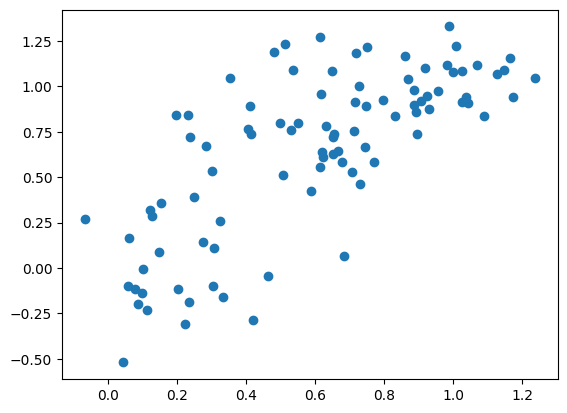

In [185]:
plt.scatter(taker_filled_orders[taker_filled_orders['symbol'] == 'KELP']['expected_edge_per_contract'], taker_filled_orders[taker_filled_orders['symbol'] == 'KELP']['retained_edge_per_contract'])
plt.show()

In [ ]:
# Given Expected Edge Per Contract, And Edge I Gain In Next Period if I fill


#  I need to decide PctTake

Bin_1, Bin_2, Bin_3, Bin_4, Bin_5.


# Additionally, this question is different whether I have 
PctTake = 

So that, given that I fill min(filled true, take percent).

I make the most amount of money.

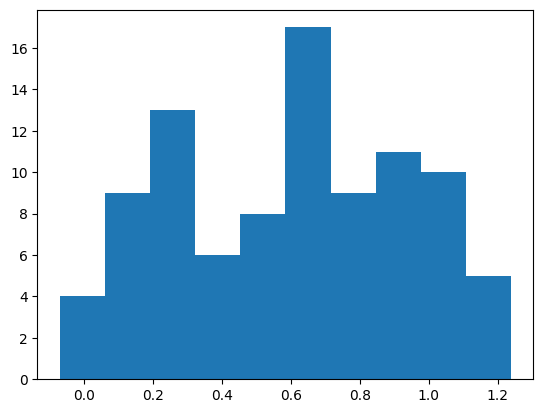

In [184]:
plt.hist(taker_filled_orders[taker_filled_orders['symbol'] == 'KELP']['expected_edge_per_contract'])
plt.show()

In [205]:
taker_filled_orders = filled_orders[filled_orders['type'] == 'taker']

display(taker_filled_orders.head())


,timestamp,symbol,price,quantity,type,offset_asked,quantity_filled,next_imc_theo,signal_theo,expected_edge_per_contract,retained_edge_per_contract,expected_edge,retained_edge,fill_percentage,offset_bucket,offset_bucket_wide,fill_percentage_bucket
158,1200,RAINFOREST_RESIN,9998,1,taker,NaN,1,10000.000000,10000.01053,2.01053,2.000000,2.01053,2.000000,1.0,NaN,NaN,0.8-1
255,2000,RAINFOREST_RESIN,9998,1,taker,NaN,1,10000.000000,10000.10047,2.10047,2.000000,2.10047,2.000000,1.0,NaN,NaN,0.8-1
298,2400,KELP,2025,1,taker,NaN,1,2025.875244,2025.93013,0.93013,0.875244,0.93013,0.875244,1.0,NaN,NaN,0.8-1
450,3600,RAINFOREST_RESIN,9998,4,taker,NaN,4,10000.000000,9999.85594,1.85594,2.000000,7.42376,8.000000,1.0,NaN,NaN,0.8-1
533,4300,KELP,2024,5,taker,NaN,5,2024.627148,2024.65192,0.65192,0.627148,3.25960,3.135742,1.0,NaN,NaN,0.8-1


In [ ]:
for product in cleaned_theos.keys():
    
    print(f"Product: {product}")

    activities_product_df = activities_df[activities_df['product'] == product]

    sell_opportunities_mask = activities_product_df['theo_price'].shift(-1) < activities_product_df['bid_price_1']
    buy_opportunities_mask = activities_product_df['theo_price'].shift(-1) > activities_product_df['ask_price_1']

    print(f"Proportion of Sell Opportunities: {np.mean(sell_opportunities_mask)}")
    print(f"Proportion of Buy Opportunities: {np.mean(buy_opportunities_mask)}")

    sell_opportunities_timestamps = activities_product_df[sell_opportunities_mask]['timestamp']
    buy_opportunities_timestamps = activities_product_df[buy_opportunities_mask]['timestamp']


### Setting minimum_edge_taker For Each Product

* Set to Multiple * MeanStdReturn * MeanPrice
* Has to do with how far from THEO original / midprice as well

### Expected Value of One Round of Market Making, Given Abs(Position) Buckets

In [210]:
maker_filled_orders.head()

,timestamp,symbol,price,quantity,type,offset_asked,quantity_filled,next_imc_theo,signal_theo,expected_edge_per_contract,retained_edge_per_contract,expected_edge,retained_edge,fill_percentage,offset_bucket,offset_bucket_wide,fill_percentage_bucket
145,1100,RAINFOREST_RESIN,9999,2,maker,0.473,2,10000.000000,9999.99594,0.99594,1.000000,1.99188,2.000000,1.0,0.2-0.5,0.2-1,0.8-1
362,2900,RAINFOREST_RESIN,9999,2,maker,0.541,2,10000.000000,10000.13901,1.13901,1.000000,2.27802,2.000000,1.0,0.5-1,0.2-1,0.8-1
380,3100,KELP,2024,5,maker,1.280,2,2024.503348,2025.00010,1.00010,0.503348,2.00020,1.006696,0.4,1-1.5,1-2,0.3-0.8
385,3100,RAINFOREST_RESIN,9999,2,maker,0.506,2,10000.000000,10000.06474,1.06474,1.000000,2.12948,2.000000,1.0,0.5-1,0.2-1,0.8-1
391,3200,KELP,2024,4,maker,0.995,2,2024.643945,2024.77758,0.77758,0.643945,1.55516,1.287891,0.5,0.5-1,0.2-1,0.3-0.8


In [ ]:
position_ranges = [0,0.2, 0.65, 1]



for symbol in maker_filled_orders['symbol'].unique():

    symbol_timestamps = position_pnl_df[position_pnl_df['product'] == symbol]['timestamp']
    symbol_positions = position_pnl_df[position_pnl_df['product'] == symbol]['position']

    for idx in range(1, len(position_ranges)):
        mask = (np.abs(symbol_positions) < position_limits[symbol] * position_ranges[idx]) & (np.abs(symbol_positions) >= position_limits[symbol] * position_ranges[idx - 1])
        timestamps_used = symbol_timestamps[mask]
            
        maker_filled_mask = maker_filled_orders[(maker_filled_orders['symbol'] == symbol) & (maker_filled_orders['timestamp'].isin(timestamps_used))]

        expected_value_market_making = maker_filled_mask.groupby('timestamp')['retained_edge_per_contract'].sum().mean()
        
        print(f"Symbol: {symbol}, Position Range: {(position_ranges[idx - 1], position_ranges[idx])}, Expected Per Contract Retained Edge: {expected_value_market_making}")

Symbol: RAINFOREST_RESIN, Position Range: (0, 0.2), Expected Retained Edge: 1.0000000000002274
Symbol: RAINFOREST_RESIN, Position Range: (0.2, 0.65), Expected Retained Edge: 1.0714285714264926
Symbol: RAINFOREST_RESIN, Position Range: (0.65, 1), Expected Retained Edge: nan
Symbol: KELP, Position Range: (0, 0.2), Expected Retained Edge: 0.5736467633929578
Symbol: KELP, Position Range: (0.2, 0.65), Expected Retained Edge: 0.6916839357983235
Symbol: KELP, Position Range: (0.65, 1), Expected Retained Edge: 1.0514707624860762


### Reducing Variance Decisions

Find E[t+2 pnl | trade to reduce variance] vs. E[t+2 pnl | dont trade]

### OOS Signal / Return Performance

In [ ]:
for symbol in trader_data_df['symbol'].unique():
    symbol_mask = trader_data_df['symbol'] == symbol
    X = trader_data_df[symbol_mask][['expected_return']]
    y = trader_data_df[symbol_mask]['return'].fillna(0)
    signal_model = sm.OLS(y, sm.add_constant(X)).fit()
    print(f"Symbol: {symbol}, R-squared: {signal_model.rsquared}, Correlation: {signal_model.rsquared ** 0.5}, Beta: {signal_model.params[1]}")

### Plotting Expected Return vs Return

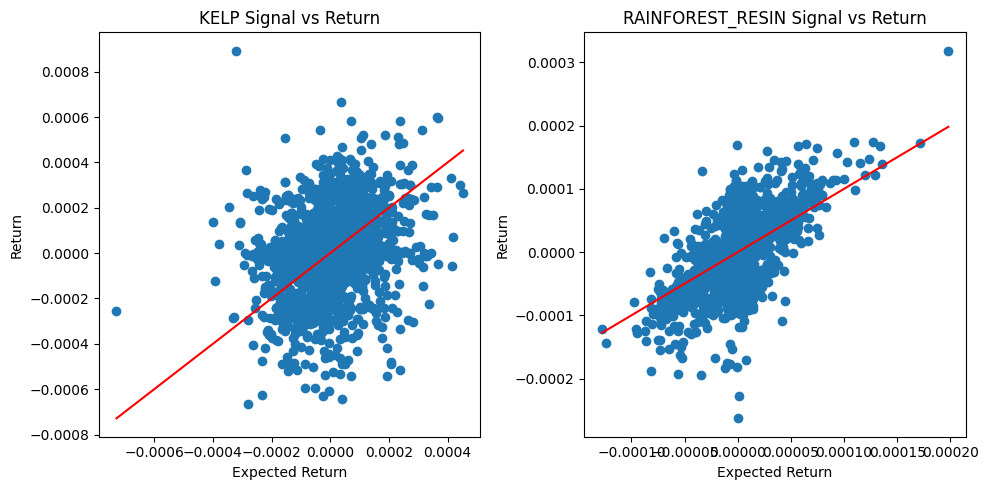

In [209]:
n_symbols = len(trader_data_df['symbol'].unique())

fig, axes = plt.subplots(1, n_symbols, figsize=(5*n_symbols, 5))

if n_symbols == 1:
    axes = np.array([axes])

for i, symbol in enumerate(trader_data_df['symbol'].unique()):
    symbol_mask = trader_data_df['symbol'] == symbol

    axes[i].scatter(trader_data_df[symbol_mask]['expected_return'], trader_data_df[symbol_mask]['return'])

    min_val, max_val = min(trader_data_df[symbol_mask]['expected_return']), max(trader_data_df[symbol_mask]['expected_return']) 

    axes[i].plot([min_val, max_val], [min_val, max_val], 'r-')
    axes[i].set_title(f'{symbol} Signal vs Return')
    axes[i].set_xlabel('Expected Return')
    axes[i].set_ylabel('Return')

plt.tight_layout()
plt.show()

### Edge Retention Analysis - Taking Orders

## Inventory Management


### Plotting Position

In [207]:
position_limits = {
    "KELP" : 50,
    "RAINFOREST_RESIN" : 50
}

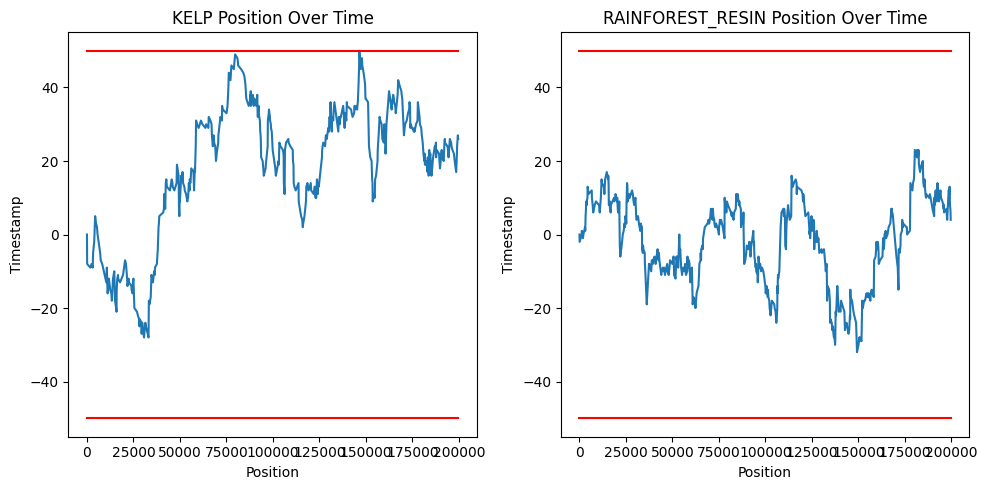

In [208]:
n_symbols = len(position_pnl_df['product'].unique())

fig, axes = plt.subplots(1, n_symbols, figsize=(5*n_symbols, 5))

if n_symbols == 1:
    axes = np.array([axes])

for i, symbol in enumerate(position_pnl_df['product'].unique()):
    symbol_mask = position_pnl_df['product'] == symbol

    axes[i].plot(position_pnl_df[symbol_mask]['timestamp'], position_pnl_df[symbol_mask]['position'])

    min_timestamp, max_timestamp = min(position_pnl_df[symbol_mask]['timestamp']), max(position_pnl_df[symbol_mask]['timestamp']) 
    position_limit = position_limits[symbol] 

    axes[i].plot([min_timestamp, max_timestamp], [position_limit, position_limit], 'r-')
    axes[i].plot([min_timestamp, max_timestamp], [-position_limit, -position_limit], 'r-')
    axes[i].set_title(f'{symbol} Position Over Time')
    axes[i].set_xlabel('Position')
    axes[i].set_ylabel('Timestamp')

plt.tight_layout()
plt.show()

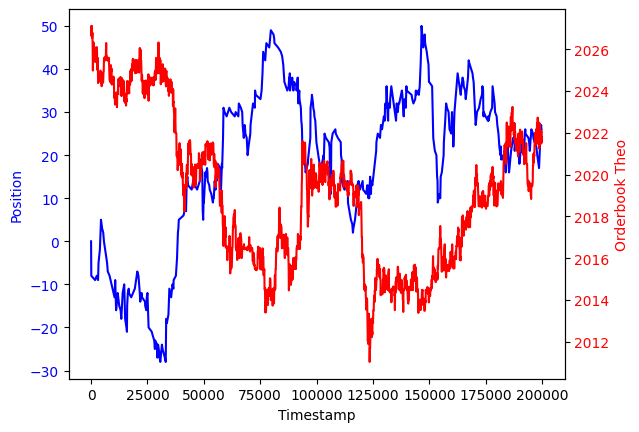

In [226]:
symbol_mask = trader_data_df['symbol'] == 'KELP'

position_symbol_mask = position_pnl_df['product'] == symbol

# Create the main figure and first axis
fig, ax1 = plt.subplots()

# Plot the first series on ax1
ax1.plot(position_pnl_df[position_symbol_mask]['timestamp'],
         position_pnl_df[position_symbol_mask]['position'],
         color='blue', label='Position')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Position', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(trader_data_df[symbol_mask]['timestamp'],
         trader_data_df[symbol_mask]['orderbook_theo'],
         color='red', label='Orderbook Theo')
ax2.set_ylabel('Orderbook Theo', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()


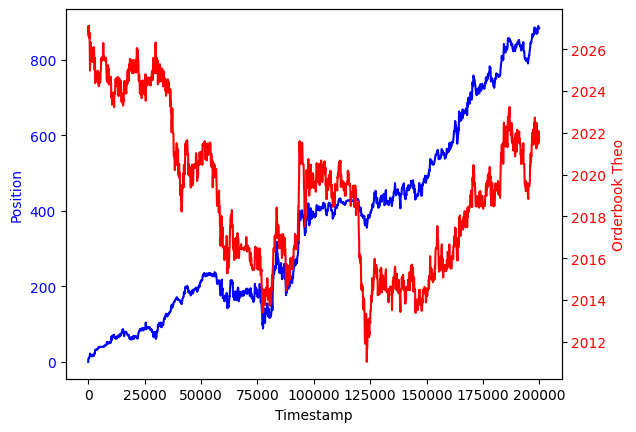

In [232]:

# Create the main figure and first axis
fig, ax1 = plt.subplots()

# Plot the first series on ax1
plt.plot(activities_df[mask]['timestamp'], 
         activities_df[mask]['profit_and_loss'],
         color='blue', label='Position')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Position', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(trader_data_df[symbol_mask]['timestamp'],
         trader_data_df[symbol_mask]['orderbook_theo'],
         color='red', label='Orderbook Theo')
ax2.set_ylabel('Orderbook Theo', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()


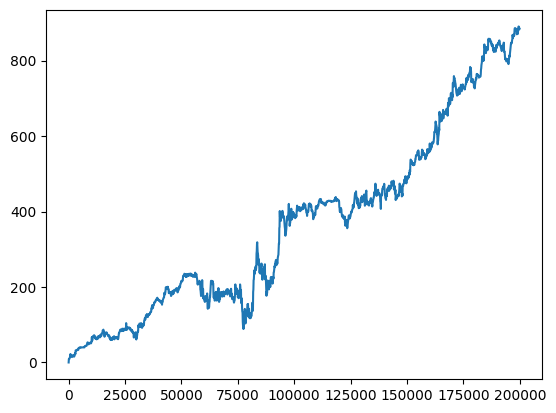

In [231]:
mask = activities_df['product'] == 'KELP'

plt.plot(activities_df[mask]['timestamp'], activities_df[mask]['profit_and_loss'])
plt.show()

### Plotting dPosition And dPnL

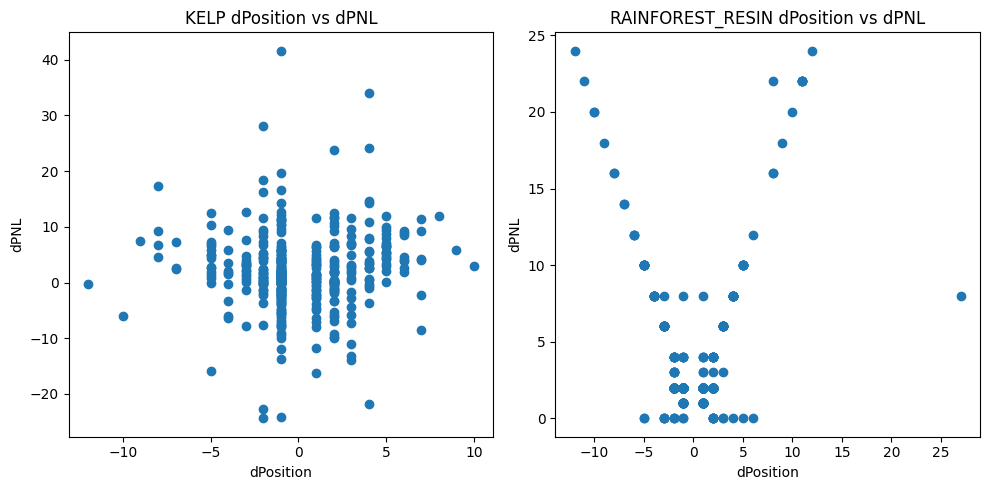

In [82]:
# Add PNL to position_pnl_df

n_symbols = len(position_pnl_df['product'].unique())

fig, axes = plt.subplots(1, n_symbols, figsize=(5*n_symbols, 5))

if n_symbols == 1:
    axes = np.array([axes])

for i, symbol in enumerate(position_pnl_df['product'].unique()):


    d_pos = merged_product_dict[symbol]['position'].diff()

    d_pnl = merged_product_dict[symbol]['profit_and_loss'].diff()

    mask = d_pos != 0

    axes[i].scatter(d_pos[mask], d_pnl[mask])
    axes[i].set_title(f'{symbol} dPosition vs dPNL')
    axes[i].set_xlabel('dPosition')
    axes[i].set_ylabel('dPNL')

plt.tight_layout()
plt.show()

### Logic On Making / Taking Orders w.r.t. Position Limits

## Volatility Forecasting

### EWMA for Variance

In [ ]:
def ewma_variance(returns, alpha, init_period=10):

    ewma_var = np.zeros_like(returns)
    for t in range(1, len(returns)):
        ewma_var[t] = (1 - alpha) * ewma_var[t-1] + alpha * returns[t-1]**2 
    return ewma_var

### Feature Generation

In [ ]:
init_period = 50
alphas_ewma = np.array([0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

mean_variance = {}
variance_alphas = {}
variance_betas = {}

for product in cleaned_theos.keys():
    
    y = cleaned_theos[product]['return_theo'].values

    future_variance = y[init_period:] ** 2

    ewma_predictors = np.zeros((len(future_variance), len(alphas_ewma)))
    for i, alpha_ewma in enumerate(alphas_ewma):
        ewma_var = ewma_variance(y, alpha_ewma)
        predictor = ewma_var[init_period-1:-1]  # Predict variance using previous EWMA (X)
        ewma_predictors[:, i] = predictor

    # Add constant term for intercept
    X = ewma_predictors

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_mean = scaler.mean_
    X_std = scaler.scale_

    # Fit Lasso with cross-validation to find the best alpha
    lasso = LassoCV(cv=5, alphas=np.logspace(-4, 2, 100), max_iter=10000).fit(X, future_variance)

    # Get R-squared
    r_squared = lasso.score(X, future_variance)

    coef_scaled = lasso.coef_  # LASSO coefficients (for standardized X)
    intercept_scaled = lasso.intercept_

    # Rescale non-constant coefficients
    coef_original = coef_scaled / X_std  # Rescale slopes
    intercept_original = intercept_scaled - np.sum(coef_scaled * X_mean / X_std)  # Adjust intercept

    # Combine intercept and rescaled coefficients
    coef_names = ['Constant'] + [f'Alpha_{alpha_ewma}' for alpha_ewma in alphas_ewma]
    coef_values = np.hstack(([intercept_original], coef_original))

    # Print summary
    coef_df = pd.DataFrame({'Coefficient': coef_names, 'Value': coef_values})
    print(f"Product: {product}")
    print(coef_df.to_string(index=False))
    print(f"R-squared: {r_squared:.4f}\n")

    coef_alphas = coef_values[1:]
    alphas_selected = alphas_ewma[coef_alphas > 0]
    coef_non_zero = np.concatenate(([intercept_original], coef_alphas[coef_alphas > 0]))

    # Assigning Parameters
    mean_variance[product] = np.mean(y)
    variance_alphas[product] = alphas_selected
    variance_betas[product] = coef_non_zero
    

    



## Random Code

In [ ]:
import itables
import itables.options as opt
opt.precision = 8 
itables.show(own_trades_df)

In [ ]:

    def har_all_features_for_product(series, lags, window_y=1):
        df = pd.DataFrame(series)
        lag_features = np.zeros((df.shape[0], len(lags)))
        for i, lag in enumerate(lags):
            if i == 0:
                lag_features[:, i] = df.rolling(lag).mean().shift(1).values.flatten()
            else:
                prev_lag = lags[i-1]
                lag_features[:, i] = (
                    (df.rolling(lag).sum().shift(1) - df.rolling(prev_lag).sum().shift(1)) / (lag - prev_lag)
                ).values.flatten()
        features_y = np.zeros(df.shape[0])
        for i in range(len(df) - window_y + 1):
            features_y[i] = df.iloc[i:i+window_y].mean().values[0]
        start_idx = max(lags)
        end_idx = len(df) - window_y + 1
        return lag_features[start_idx:end_idx], features_y[start_idx:end_idx]

